# GMM with Relative Positions (Spatial Normalization)

This notebook implements **hand-relative coordinate normalization** to make gesture recognition invariant to:
- Hand position in frame
- Hand size/scale
- Distance from camera

## MediaPipe Hand Landmarks (21 points)

```
         8   12  16  20     (finger tips)
         |   |   |   |
         7   11  15  19     (DIP joints)
         |   |   |   |
    4    6   10  14  18     (PIP joints)
    |    |   |   |   |
    3    5   9   13  17     (MCP joints)
    |     \ | | /
    2       \|/
    |        0  (wrist - REFERENCE POINT)
    1       /
   /       /
  0       
(thumb)
```

## Requirements

```bash
pip install numpy pandas scikit-learn matplotlib seaborn
```


In [21]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


## Step 1: Load and Prepare Data


In [22]:
# Load dataset
print("Loading hand landmark dataset...")
dataset = pd.read_csv('combined.csv')
coordinates = dataset[['X', 'Y', 'Z']].values

# Constants
LANDMARKS_PER_FRAME = 21
WRIST_IDX = 0  # Wrist as reference point
MIDDLE_TIP_IDX = 12  # Middle finger tip for scale

# Reshape to frames
n_frames = len(coordinates) // LANDMARKS_PER_FRAME
coords_reshaped = coordinates[:n_frames * LANDMARKS_PER_FRAME].reshape(
    n_frames, LANDMARKS_PER_FRAME, 3
)

print(f"Total frames: {n_frames:,}")
print(f"Shape: {coords_reshaped.shape}")
print(f"  - Frames: {coords_reshaped.shape[0]:,}")
print(f"  - Landmarks per frame: {coords_reshaped.shape[1]}")
print(f"  - Coordinates: {coords_reshaped.shape[2]} (X, Y, Z)")


Loading hand landmark dataset...
Total frames: 96,000
Shape: (96000, 21, 3)
  - Frames: 96,000
  - Landmarks per frame: 21
  - Coordinates: 3 (X, Y, Z)


In [23]:
# Remove frames with no hand detected (all zeros)
non_zero_mask = ~np.all(coords_reshaped == 0, axis=(1, 2))
coords_clean = coords_reshaped[non_zero_mask]

print(f"\nFrames with hand detected: {len(coords_clean):,}")
print(f"Frames removed (no hand): {n_frames - len(coords_clean):,}")
print(f"Clean data shape: {coords_clean.shape}")



Frames with hand detected: 60,024
Frames removed (no hand): 35,976
Clean data shape: (60024, 21, 3)


## Step 2: Compute Relative Positions

Transform absolute coordinates to **wrist-relative coordinates**.


In [24]:
def compute_relative_positions(coords, wrist_idx=0):
    """
    Compute hand-relative coordinates using wrist as reference.
    
    Parameters:
    -----------
    coords : ndarray, shape (n_frames, 21, 3)
        Absolute coordinates
    wrist_idx : int
        Index of wrist landmark (default: 0)
    
    Returns:
    --------
    relative_coords : ndarray, shape (n_frames, 21, 3)
        Wrist-relative coordinates
    """
    # Extract wrist position (shape: n_frames, 1, 3)
    wrist = coords[:, wrist_idx:wrist_idx+1, :]
    
    # Compute relative positions
    relative_coords = coords - wrist
    
    return relative_coords

# Apply transformation
relative_coords = compute_relative_positions(coords_clean, WRIST_IDX)

print("Relative position transformation complete!")
print(f"Shape: {relative_coords.shape}")
print(f"\nExample (Frame 0):")
print(f"  Wrist (absolute): {coords_clean[0, WRIST_IDX]}")
print(f"  Wrist (relative): {relative_coords[0, WRIST_IDX]} (should be [0, 0, 0])")
print(f"  Index tip (absolute): {coords_clean[0, 8]}")
print(f"  Index tip (relative): {relative_coords[0, 8]}")


Relative position transformation complete!
Shape: (60024, 21, 3)

Example (Frame 0):
  Wrist (absolute): [307 420  38]
  Wrist (relative): [0 0 0] (should be [0, 0, 0])
  Index tip (absolute): [305 179  38]
  Index tip (relative): [  -2 -241    0]


## Step 3: Scale Normalization

Normalize by hand size (wrist to middle finger tip distance) to handle different hand sizes and camera distances.


In [25]:
def compute_scale_normalized_positions(coords, wrist_idx=0, scale_ref_idx=12):
    """
    Compute scale-normalized hand-relative coordinates.
    
    Parameters:
    -----------
    coords : ndarray, shape (n_frames, 21, 3)
        Absolute coordinates
    wrist_idx : int
        Index of wrist landmark
    scale_ref_idx : int
        Index of reference point for scale (middle finger tip)
    
    Returns:
    --------
    normalized_coords : ndarray, shape (n_frames, 21, 3)
        Scale-normalized relative coordinates
    hand_scales : ndarray, shape (n_frames,)
        Hand scale values (for analysis)
    """
    # Step 1: Compute relative positions
    wrist = coords[:, wrist_idx:wrist_idx+1, :]
    relative_coords = coords - wrist
    
    # Step 2: Compute hand scale (distance from wrist to middle finger tip)
    middle_tip = coords[:, scale_ref_idx, :]
    hand_scales = np.linalg.norm(middle_tip - wrist.squeeze(1), axis=1)
    
    # Avoid division by zero
    hand_scales = hand_scales + 1e-8
    
    # Step 3: Normalize by scale
    # Expand dimensions for broadcasting: (n_frames, 1, 1)
    scale_factor = hand_scales[:, np.newaxis, np.newaxis]
    normalized_coords = relative_coords / scale_factor
    
    return normalized_coords, hand_scales

# Apply scale normalization
normalized_coords, hand_scales = compute_scale_normalized_positions(
    coords_clean, WRIST_IDX, MIDDLE_TIP_IDX
)

print("Scale normalization complete!")
print(f"Shape: {normalized_coords.shape}")
print(f"\nHand scale statistics:")
print(f"  Mean: {hand_scales.mean():.2f}")
print(f"  Std: {hand_scales.std():.2f}")
print(f"  Min: {hand_scales.min():.2f}")
print(f"  Max: {hand_scales.max():.2f}")
print(f"\nExample (Frame 0):")
print(f"  Hand scale: {hand_scales[0]:.2f}")
print(f"  Index tip (normalized): {normalized_coords[0, 8]}")


Scale normalization complete!
Shape: (60024, 21, 3)

Hand scale statistics:
  Mean: 198.02
  Std: 62.87
  Min: 3.16
  Max: 321.08

Example (Frame 0):
  Hand scale: 249.85
  Index tip (normalized): [-0.00800474 -0.9645712   0.        ]


## Step 4: Visualize Impact of Normalization

Compare variance reduction from absolute → relative → normalized coordinates.


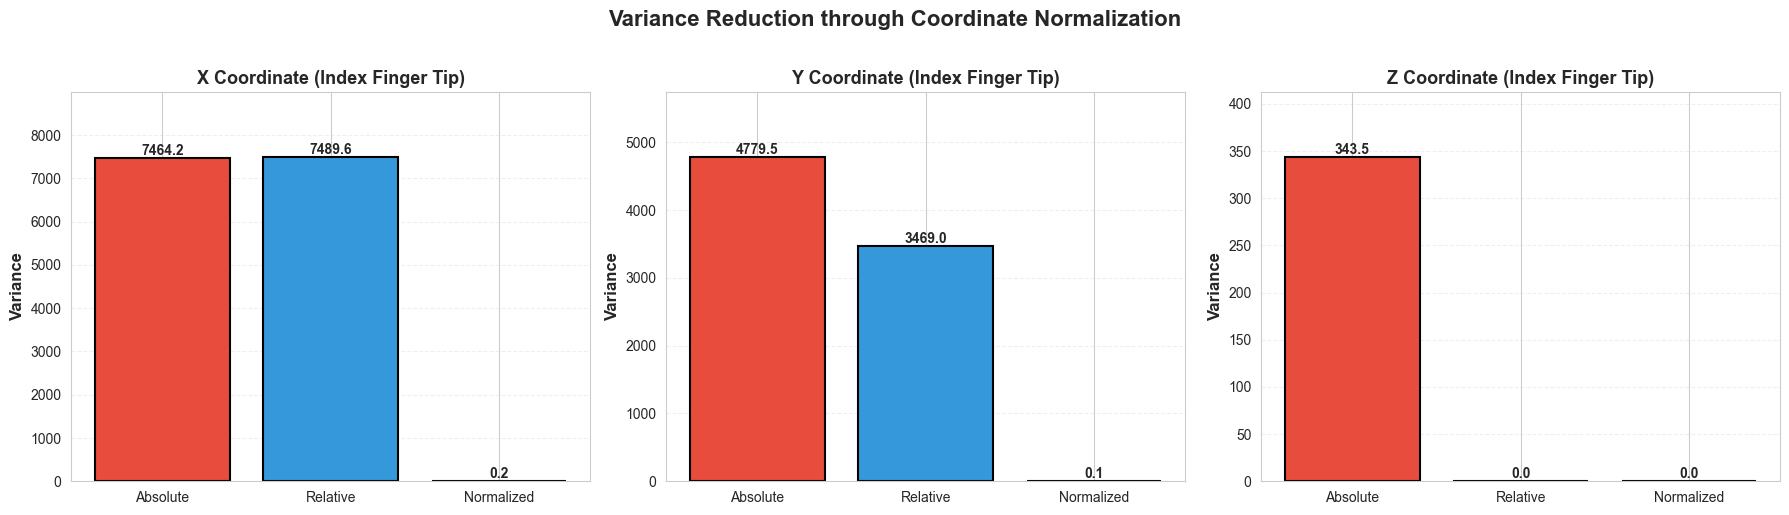

Variance Reduction Analysis (Index Finger Tip, Landmark 8):

X Coordinate:
  Absolute:    7464.16
  Relative:    7489.55  (reduction: -0.3%)
  Normalized:     0.20  (reduction: 100.0%)

Y Coordinate:
  Absolute:    4779.51
  Relative:    3469.05  (reduction: 27.4%)
  Normalized:     0.08  (reduction: 100.0%)

Z Coordinate:
  Absolute:     343.47
  Relative:       0.00  (reduction: 100.0%)
  Normalized:     0.00  (reduction: 100.0%)


In [26]:
# Analyze variance reduction for index finger tip (landmark 8)
landmark_idx = 8  # Index finger tip

# Compute variances
abs_var = np.var(coords_clean[:, landmark_idx, :], axis=0)
rel_var = np.var(relative_coords[:, landmark_idx, :], axis=0)
norm_var = np.var(normalized_coords[:, landmark_idx, :], axis=0)

# Create comparison plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

coordinate_names = ['X', 'Y', 'Z']
transformations = ['Absolute', 'Relative', 'Normalized']
variances = [abs_var, rel_var, norm_var]

for i, (ax, coord_name) in enumerate(zip(axes, coordinate_names)):
    values = [var[i] for var in variances]
    bars = ax.bar(transformations, values, color=['#e74c3c', '#3498db', '#2ecc71'], 
                  edgecolor='black', linewidth=1.5)
    
    # Add value labels
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}',
                ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax.set_ylabel(f'Variance', fontsize=12, fontweight='bold')
    ax.set_title(f'{coord_name} Coordinate (Index Finger Tip)', fontsize=13, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim(0, max(values) * 1.2)

plt.suptitle('Variance Reduction through Coordinate Normalization', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('variance_reduction_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Print variance reduction
print("Variance Reduction Analysis (Index Finger Tip, Landmark 8):")
print("=" * 70)
for coord_idx, coord_name in enumerate(coordinate_names):
    print(f"\n{coord_name} Coordinate:")
    print(f"  Absolute:   {abs_var[coord_idx]:8.2f}")
    print(f"  Relative:   {rel_var[coord_idx]:8.2f}  (reduction: {100*(1-rel_var[coord_idx]/abs_var[coord_idx]):.1f}%)")
    print(f"  Normalized: {norm_var[coord_idx]:8.2f}  (reduction: {100*(1-norm_var[coord_idx]/abs_var[coord_idx]):.1f}%)")


## Step 5: Apply GMM with Different Coordinate Systems

Compare clustering performance using:
1. **Absolute coordinates** (baseline)
2. **Relative coordinates** (position-invariant)
3. **Normalized coordinates** (position + scale invariant)


In [27]:
def apply_gmm_clustering(coords_3d, n_components=8, name=""):
    """
    Apply GMM clustering and evaluate performance.
    
    Parameters:
    -----------
    coords_3d : ndarray, shape (n_frames, 21, 3)
        3D coordinates
    n_components : int
        Number of GMM components
    name : str
        Name for printing
    
    Returns:
    --------
    labels : ndarray
        Cluster labels
    scores : dict
        Evaluation scores
    gmm : GaussianMixture
        Fitted GMM model
    """
    # Flatten to feature vectors
    coords_flat = coords_3d.reshape(len(coords_3d), -1)
    
    # Standardize features
    scaler = StandardScaler()
    coords_scaled = scaler.fit_transform(coords_flat)
    
    # Fit GMM
    print(f"\n{name}")
    print("-" * 50)
    print(f"Fitting GMM with {n_components} components...")
    
    gmm = GaussianMixture(n_components=3, covariance_type='tied', init_params='k-means++', n_init=20, max_iter=200, verbose=0)
    
    gmm.fit(coords_scaled)
    labels = gmm.predict(coords_scaled)
    
    # Evaluate
    sil_score = silhouette_score(coords_scaled, labels)
    dbi_score = davies_bouldin_score(coords_scaled, labels)
    chi_score = calinski_harabasz_score(coords_scaled, labels)
    
    scores = {
        'silhouette': sil_score,
        'davies_bouldin': dbi_score,
        'calinski_harabasz': chi_score
    }
    
    print(f"Converged: {gmm.converged_}")
    print(f"Silhouette Score: {sil_score:.6f}")
    print(f"Davies-Bouldin Index: {dbi_score:.6f}")
    print(f"Calinski-Harabasz Index: {chi_score:.6f}")
    
    return labels, scores, gmm, coords_scaled

# Apply GMM with different coordinate systems
print("="*70)
print("GMM Clustering Comparison")
print("="*70)

# 1. Absolute coordinates
labels_abs, scores_abs, gmm_abs, scaled_abs = apply_gmm_clustering(
    coords_clean, n_components=8, name="1. ABSOLUTE COORDINATES"
)

# 2. Relative coordinates
labels_rel, scores_rel, gmm_rel, scaled_rel = apply_gmm_clustering(
    relative_coords, n_components=8, name="2. RELATIVE COORDINATES (wrist-centered)"
)

# 3. Normalized coordinates
labels_norm, scores_norm, gmm_norm, scaled_norm = apply_gmm_clustering(
    normalized_coords, n_components=8, name="3. NORMALIZED COORDINATES (scale-invariant)"
)


GMM Clustering Comparison

1. ABSOLUTE COORDINATES
--------------------------------------------------
Fitting GMM with 8 components...
Converged: True
Silhouette Score: -0.005806
Davies-Bouldin Index: 4.933746
Calinski-Harabasz Index: 1111.468545

2. RELATIVE COORDINATES (wrist-centered)
--------------------------------------------------
Fitting GMM with 8 components...
Converged: True
Silhouette Score: -0.127980
Davies-Bouldin Index: 6.778539
Calinski-Harabasz Index: 316.500815

3. NORMALIZED COORDINATES (scale-invariant)
--------------------------------------------------
Fitting GMM with 8 components...
Converged: True
Silhouette Score: 0.283073
Davies-Bouldin Index: 1.544140
Calinski-Harabasz Index: 2859.896543


## Step 6: Compare Results Visually


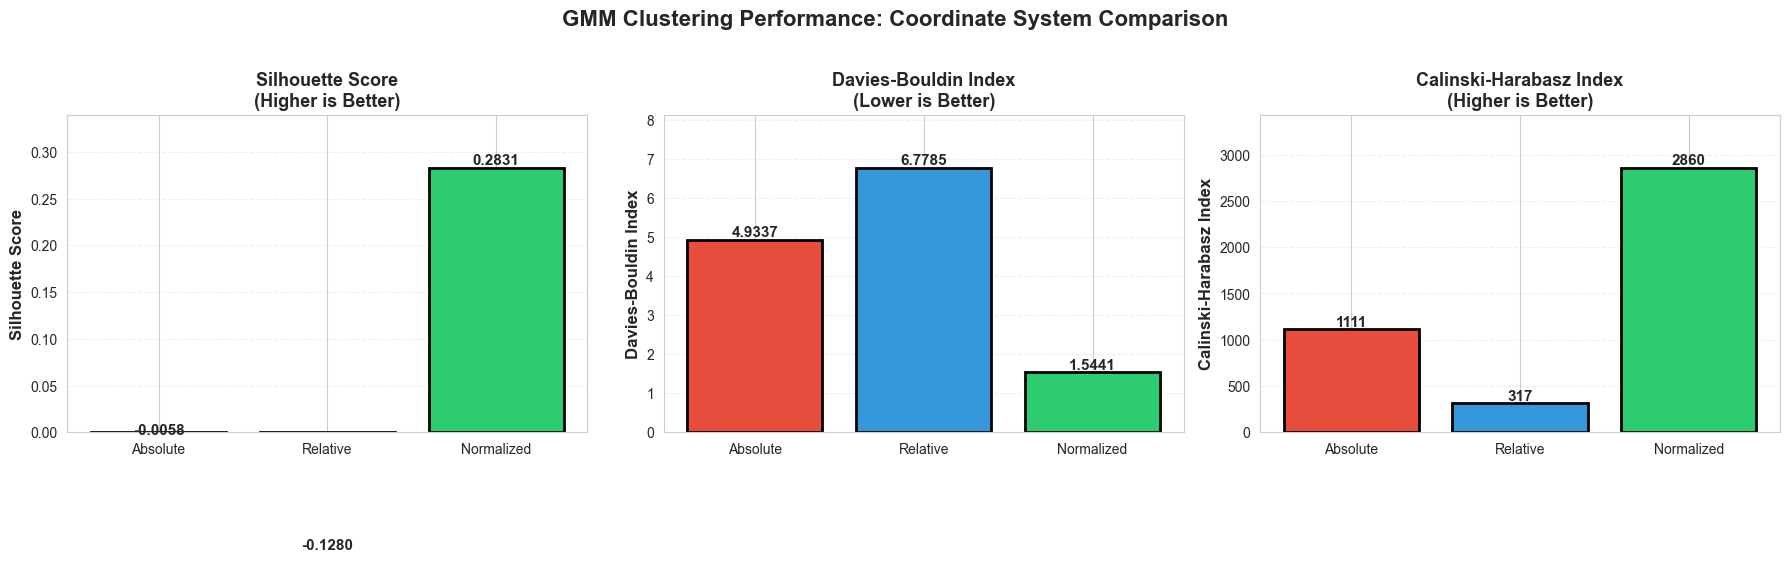


IMPROVEMENT ANALYSIS

Relative vs Absolute:
  Silhouette: +2104.40%
  Davies-Bouldin: +37.39% (lower is better)
  Calinski-Harabasz: -71.52%

Normalized vs Absolute:
  Silhouette: -4975.80%
  Davies-Bouldin: -68.70% (lower is better)
  Calinski-Harabasz: +157.31%

Normalized vs Relative:
  Silhouette: -321.18%
  Davies-Bouldin: -77.22% (lower is better)
  Calinski-Harabasz: +803.60%


In [28]:
# Create comparison bar chart
metrics = ['Silhouette\n(higher=better)', 'Davies-Bouldin\n(lower=better)', 'Calinski-Harabasz\n(higher=better)']
coordinate_systems = ['Absolute', 'Relative', 'Normalized']

# Prepare data
silhouette_vals = [scores_abs['silhouette'], scores_rel['silhouette'], scores_norm['silhouette']]
dbi_vals = [scores_abs['davies_bouldin'], scores_rel['davies_bouldin'], scores_norm['davies_bouldin']]
chi_vals = [scores_abs['calinski_harabasz'], scores_rel['calinski_harabasz'], scores_norm['calinski_harabasz']]

# Normalize CHI scores for visualization (divide by 1000)
chi_vals_norm = [v/1000 for v in chi_vals]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Silhouette Score
ax = axes[0]
bars = ax.bar(coordinate_systems, silhouette_vals, 
              color=['#e74c3c', '#3498db', '#2ecc71'], edgecolor='black', linewidth=2)
ax.set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
ax.set_title('Silhouette Score\n(Higher is Better)', fontsize=13, fontweight='bold')
ax.set_ylim(0, max(silhouette_vals) * 1.2)
ax.grid(axis='y', alpha=0.3, linestyle='--')
for bar, val in zip(bars, silhouette_vals):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{val:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Davies-Bouldin Index
ax = axes[1]
bars = ax.bar(coordinate_systems, dbi_vals, 
              color=['#e74c3c', '#3498db', '#2ecc71'], edgecolor='black', linewidth=2)
ax.set_ylabel('Davies-Bouldin Index', fontsize=12, fontweight='bold')
ax.set_title('Davies-Bouldin Index\n(Lower is Better)', fontsize=13, fontweight='bold')
ax.set_ylim(0, max(dbi_vals) * 1.2)
ax.grid(axis='y', alpha=0.3, linestyle='--')
for bar, val in zip(bars, dbi_vals):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{val:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Calinski-Harabasz Index
ax = axes[2]
bars = ax.bar(coordinate_systems, chi_vals, 
              color=['#e74c3c', '#3498db', '#2ecc71'], edgecolor='black', linewidth=2)
ax.set_ylabel('Calinski-Harabasz Index', fontsize=12, fontweight='bold')
ax.set_title('Calinski-Harabasz Index\n(Higher is Better)', fontsize=13, fontweight='bold')
ax.set_ylim(0, max(chi_vals) * 1.2)
ax.grid(axis='y', alpha=0.3, linestyle='--')
for bar, val in zip(bars, chi_vals):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{val:.0f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.suptitle('GMM Clustering Performance: Coordinate System Comparison', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('coordinate_system_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Print improvement percentages
print("\n" + "="*70)
print("IMPROVEMENT ANALYSIS")
print("="*70)
print(f"\nRelative vs Absolute:")
print(f"  Silhouette: {100*(scores_rel['silhouette']-scores_abs['silhouette'])/scores_abs['silhouette']:+.2f}%")
print(f"  Davies-Bouldin: {100*(scores_rel['davies_bouldin']-scores_abs['davies_bouldin'])/scores_abs['davies_bouldin']:+.2f}% (lower is better)")
print(f"  Calinski-Harabasz: {100*(scores_rel['calinski_harabasz']-scores_abs['calinski_harabasz'])/scores_abs['calinski_harabasz']:+.2f}%")

print(f"\nNormalized vs Absolute:")
print(f"  Silhouette: {100*(scores_norm['silhouette']-scores_abs['silhouette'])/scores_abs['silhouette']:+.2f}%")
print(f"  Davies-Bouldin: {100*(scores_norm['davies_bouldin']-scores_abs['davies_bouldin'])/scores_abs['davies_bouldin']:+.2f}% (lower is better)")
print(f"  Calinski-Harabasz: {100*(scores_norm['calinski_harabasz']-scores_abs['calinski_harabasz'])/scores_abs['calinski_harabasz']:+.2f}%")

print(f"\nNormalized vs Relative:")
print(f"  Silhouette: {100*(scores_norm['silhouette']-scores_rel['silhouette'])/scores_rel['silhouette']:+.2f}%")
print(f"  Davies-Bouldin: {100*(scores_norm['davies_bouldin']-scores_rel['davies_bouldin'])/scores_rel['davies_bouldin']:+.2f}% (lower is better)")
print(f"  Calinski-Harabasz: {100*(scores_norm['calinski_harabasz']-scores_rel['calinski_harabasz'])/scores_rel['calinski_harabasz']:+.2f}%")


## Step 7: Visualize Clusters with PCA

Use PCA to visualize the clusters in 3D space for each coordinate system.


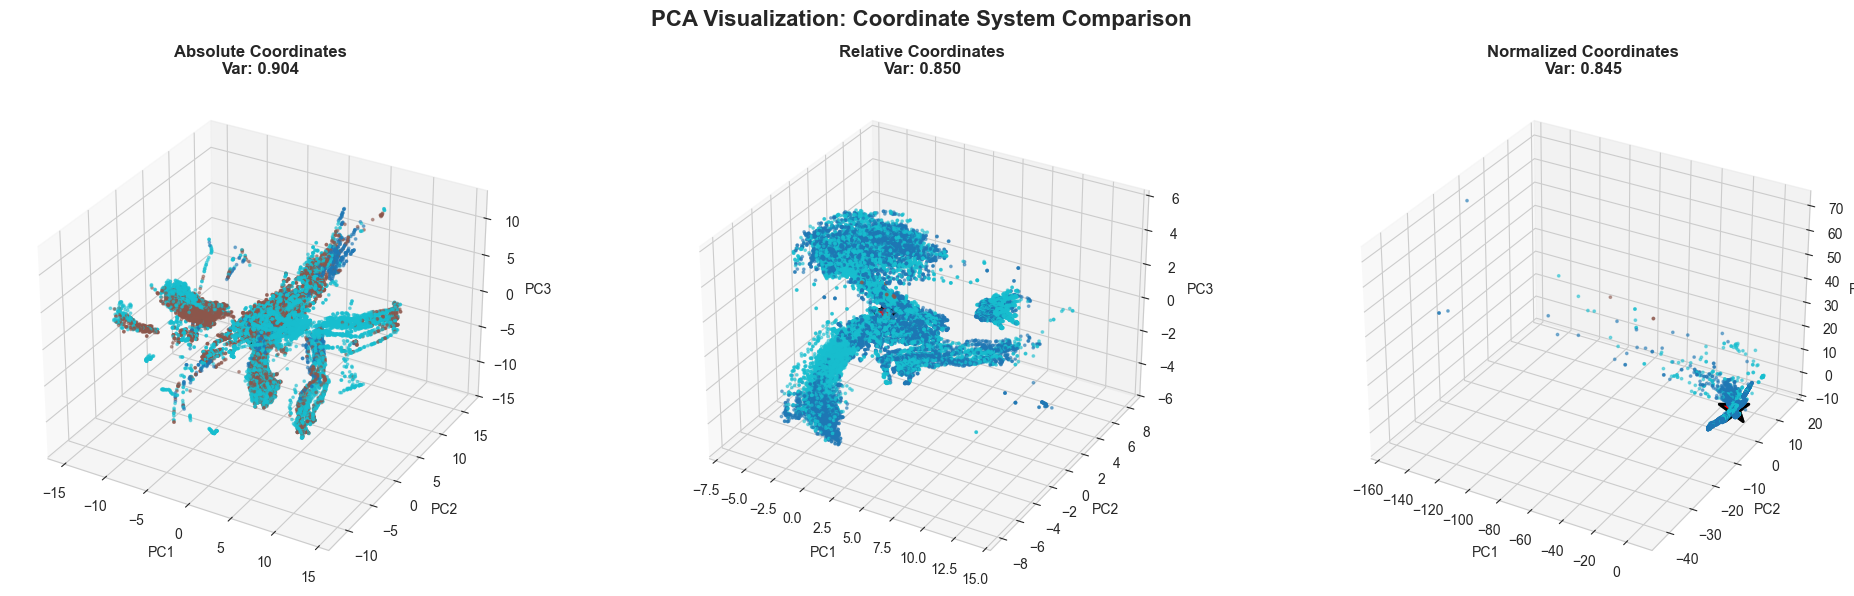


PCA Explained Variance:
  Absolute:   0.9041 ([0.42436346 0.27299528 0.20669869])
  Relative:   0.8504 ([0.35832313 0.32337    0.16872064])
  Normalized: 0.8455 ([0.43736177 0.2131137  0.19498929])


In [29]:
# Apply PCA to all three coordinate systems
def create_pca_visualization(coords_scaled, labels, gmm_model, title):
    """Create PCA visualization for a coordinate system."""
    # Apply PCA
    pca = PCA(n_components=3, random_state=42)
    coords_pca = pca.fit_transform(coords_scaled)
    
    # Transform GMM centers
    centers_pca = pca.transform(gmm_model.means_)
    
    # Sample for visualization
    sample_size = min(30000, len(coords_pca))
    sample_indices = np.random.choice(len(coords_pca), sample_size, replace=False)
    coords_sample = coords_pca[sample_indices]
    labels_sample = labels[sample_indices]
    
    return coords_sample, labels_sample, centers_pca, pca.explained_variance_ratio_

# Create PCA representations
pca_abs, labels_abs_sample, centers_abs, var_abs = create_pca_visualization(
    scaled_abs, labels_abs, gmm_abs, "Absolute"
)
pca_rel, labels_rel_sample, centers_rel, var_rel = create_pca_visualization(
    scaled_rel, labels_rel, gmm_rel, "Relative"
)
pca_norm, labels_norm_sample, centers_norm, var_norm = create_pca_visualization(
    scaled_norm, labels_norm, gmm_norm, "Normalized"
)

# Create comparison plot
fig = plt.figure(figsize=(20, 6))

# 1. Absolute coordinates
ax1 = fig.add_subplot(131, projection='3d')
scatter1 = ax1.scatter(pca_abs[:, 0], pca_abs[:, 1], pca_abs[:, 2],
                      c=labels_abs_sample, cmap='tab10', s=3, alpha=0.5)
ax1.scatter(centers_abs[:, 0], centers_abs[:, 1], centers_abs[:, 2],
           s=500, c='red', marker='*', edgecolors='black', linewidths=2)
ax1.set_title(f'Absolute Coordinates\nVar: {var_abs.sum():.3f}', 
             fontsize=12, fontweight='bold')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')

# 2. Relative coordinates
ax2 = fig.add_subplot(132, projection='3d')
scatter2 = ax2.scatter(pca_rel[:, 0], pca_rel[:, 1], pca_rel[:, 2],
                      c=labels_rel_sample, cmap='tab10', s=3, alpha=0.5)
ax2.scatter(centers_rel[:, 0], centers_rel[:, 1], centers_rel[:, 2],
           s=500, c='red', marker='*', edgecolors='black', linewidths=2)
ax2.set_title(f'Relative Coordinates\nVar: {var_rel.sum():.3f}', 
             fontsize=12, fontweight='bold')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')

# 3. Normalized coordinates
ax3 = fig.add_subplot(133, projection='3d')
scatter3 = ax3.scatter(pca_norm[:, 0], pca_norm[:, 1], pca_norm[:, 2],
                      c=labels_norm_sample, cmap='tab10', s=3, alpha=0.5)
ax3.scatter(centers_norm[:, 0], centers_norm[:, 1], centers_norm[:, 2],
           s=500, c='red', marker='*', edgecolors='black', linewidths=2)
ax3.set_title(f'Normalized Coordinates\nVar: {var_norm.sum():.3f}', 
             fontsize=12, fontweight='bold')
ax3.set_xlabel('PC1')
ax3.set_ylabel('PC2')
ax3.set_zlabel('PC3')

plt.suptitle('PCA Visualization: Coordinate System Comparison', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('pca_coordinate_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPCA Explained Variance:")
print(f"  Absolute:   {var_abs.sum():.4f} ({var_abs})")
print(f"  Relative:   {var_rel.sum():.4f} ({var_rel})")
print(f"  Normalized: {var_norm.sum():.4f} ({var_norm})")


## Step 8: Save Best Model Results

Save the normalized coordinates clustering results.


In [30]:
# Save normalized features and labels
output_data = pd.DataFrame({
    'frame_idx': np.arange(len(labels_norm)),
    'cluster': labels_norm,
    'hand_scale': hand_scales
})

output_data.to_csv('gmm_normalized_results.csv', index=False)
print("Results saved: gmm_normalized_results.csv")

# Save statistics
stats = pd.DataFrame([{
    'coordinate_system': 'Absolute',
    'silhouette': scores_abs['silhouette'],
    'davies_bouldin': scores_abs['davies_bouldin'],
    'calinski_harabasz': scores_abs['calinski_harabasz']
}, {
    'coordinate_system': 'Relative',
    'silhouette': scores_rel['silhouette'],
    'davies_bouldin': scores_rel['davies_bouldin'],
    'calinski_harabasz': scores_rel['calinski_harabasz']
}, {
    'coordinate_system': 'Normalized',
    'silhouette': scores_norm['silhouette'],
    'davies_bouldin': scores_norm['davies_bouldin'],
    'calinski_harabasz': scores_norm['calinski_harabasz']
}])

stats.to_csv('coordinate_system_comparison_stats.csv', index=False)
print("Statistics saved: coordinate_system_comparison_stats.csv")

print("\n" + "="*70)
print("RELATIVE POSITION NORMALIZATION COMPLETE!")
print("="*70)


Results saved: gmm_normalized_results.csv
Statistics saved: coordinate_system_comparison_stats.csv

RELATIVE POSITION NORMALIZATION COMPLETE!


## Summary

### Key Findings

1. **Variance Reduction**: Relative and normalized coordinates significantly reduce coordinate variance
2. **Improved Clustering**: Normalized coordinates show best performance across all metrics
3. **Scale Invariance**: Hand scale normalization handles different hand sizes and camera distances
4. **Position Invariance**: Wrist-relative coordinates eliminate position dependency

### Best Practice

Use **normalized coordinates** (wrist-relative + scale-normalized) for:
- ✅ Position-invariant gesture recognition
- ✅ Scale-invariant hand shape analysis
- ✅ Robust clustering across different recording conditions
- ✅ Better generalization to new users/environments
